# Group G3


*   Paul Miller (Team Lead)
*   Dhyey Joshi
*   Jui Ambikar






# **Loading necessary Library**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import math
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from numpy.random import normal, seed

import plotly.graph_objects as go

In [28]:
import os
models_dir = 'models'
saved_models = os.listdir(models_dir)
selected_model = 'fix'
model_path = os.path.join(models_dir, selected_model)
print(model_path)

models\fix


# Pre-processing of Dataset

**Import US Census income by education level data in Table A-3**

The table contains average annual salaries by year for all levels of education.

In [29]:
salaries_df = pd.read_excel('data/Census-edu_attainment_taba-3.xlsx', skiprows=3)
salaries_df.head(10)

,Year,Total,Unnamed: 2,Unnamed: 3,Not a high school graduate,Unnamed: 5,Unnamed: 6,High school graduate,Unnamed: 8,Unnamed: 9,Some college/associate's degree,Unnamed: 11,Unnamed: 12,Bachelor's degree,Unnamed: 14,Unnamed: 15,Advanced degree,Unnamed: 17,Unnamed: 18
0,NaN,Number with earnings,Mean,Standard error,Number with earnings,Mean,Standard error,Number with earnings,Mean,Standard error,Number with earnings,Mean,Standard error,Number with earnings,Mean,Standard error,Number with earnings,Mean,Standard error
1,"Total, Both Sexes",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,165282,63050,348,10886,31050,843,43930,42850,431,44019,48070,456,41873,80380,781,24572,110600,1334
3,2020,164611,72520,386,10985,35940,852,42240,39498,456,45240,44176,456,41910,73499,695,24236,104833,1422
4,2019,167216,52380,362,11414,22810,537,42599,39371,315,46886,45091,390,42153,73163,767,24164,106766,1397
5,2018,165179,64340,296,12058,31870,481,42882,38936,376,46887,43053,416,40231,71155,676,23118,99919,1186
6,2017,163871,74320,218,12240,36980,383,42816,38145,320,47382,41507,291,39153,67763,462,22277,98369,933
7,2016,162218,52590,217,12281,22490,559,42897,36702,296,48128,40201,277,37272,67267,508,21639,95203,909
8,2015,161074,69240,209,13159,30360,422,42404,35615,271,47961,38943,261,36348,65482,516,21199,92525,898
9,2014,158000,80930,196,13197,34530,494,42529,34099,240,47023,37945,283,35305,62466,452,19944,88056,855


**Drop and clean up column names**

In [30]:
salaries_df.drop(salaries_df.columns[[3, 6, 9, 12, 15, 18]],axis = 1, inplace=True)
salaries_df.head()

,Year,Total,Unnamed: 2,Not a high school graduate,Unnamed: 5,High school graduate,Unnamed: 8,Some college/associate's degree,Unnamed: 11,Bachelor's degree,Unnamed: 14,Advanced degree,Unnamed: 17
0,NaN,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean
1,"Total, Both Sexes",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
3,2020,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
4,2019,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766


Rename all columns to a new list instead of changing one by one

In [31]:
new_columns = ['year','total_earners','total_earners_salary',
               'no_high_school_earners', 'no_high_school_salary',
               'high_school_earners', 'high_school_salary',
               'some_college_earners', 'some_college_salary',
              'bachelors_earners', 'bachelors_salary',
               'adv_earners', 'adv_salary']
salaries_df.columns = new_columns
salaries_df.head()

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
0,NaN,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean,Number with earnings,Mean
1,"Total, Both Sexes",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
3,2020,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
4,2019,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766


In [32]:
salaries_df.drop([0,1], inplace=True)

In [33]:
salaries_df.iloc[42:53]

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
44,1979,110826,11795,23783,8420,45497,10624,21174,11377,11751,16514,8621,21874
45,1978,106436,10812,23787,7759,43510,9834,20121,10357,11001,15291,8017,20173
46,1977,103119,9887,24854,7066,41696,9013,18905,9607,10357,14207,7309,19077
47,1976,100510,9180,25035,6720,40570,8393,17786,8813,10132,13033,6985,17911
48,1975,97881,8552,24916,6198,39827,7843,16917,8388,9764,12332,6457,16725
49,"Total, Male",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,2021,87547,72520,6830,35940,26119,48480,22365,56650,20918,96390,11313,137300
51,2020,86512,67964,6881,33402,24995,45276,22613,53097,20680,88447,11343,131221
52,2019,87768,67784,7074,33825,24980,45188,23342,54045,20828,87399,11543,129883
53,2018,86913,65058,7520,31846,24992,45259,23286,52460,20083,84803,11029,123215


Keep only top 49 rows which are for both genders and all races. The lower tables slice up the date by gender and race.

In [34]:
salaries_df = salaries_df.iloc[0:47]
salaries_df.reset_index(inplace=True, drop=True)
salaries_df.head()

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
0,2021,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
1,2020,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
2,2019,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766
3,2018,165179,64340,12058,31870,42882,38936,46887,43053,40231,71155,23118,99919
4,2017,163871,74320,12240,36980,42816,38145,47382,41507,39153,67763,22277,98369


In [35]:
salaries_df.tail()

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
42,1979,110826,11795,23783,8420,45497,10624,21174,11377,11751,16514,8621,21874
43,1978,106436,10812,23787,7759,43510,9834,20121,10357,11001,15291,8017,20173
44,1977,103119,9887,24854,7066,41696,9013,18905,9607,10357,14207,7309,19077
45,1976,100510,9180,25035,6720,40570,8393,17786,8813,10132,13033,6985,17911
46,1975,97881,8552,24916,6198,39827,7843,16917,8388,9764,12332,6457,16725


Check for any null values

In [36]:
salaries_df.isnull().sum()

year                      0
total_earners             0
total_earners_salary      0
no_high_school_earners    0
no_high_school_salary     0
high_school_earners       0
high_school_salary        0
some_college_earners      0
some_college_salary       0
bachelors_earners         0
bachelors_salary          0
adv_earners               0
adv_salary                0
dtype: int64

In [37]:
salaries_df

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
0,2021,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
1,2020,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
2,2019,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766
3,2018,165179,64340,12058,31870,42882,38936,46887,43053,40231,71155,23118,99919
4,2017,163871,74320,12240,36980,42816,38145,47382,41507,39153,67763,22277,98369
5,2016,162218,52590,12281,22490,42897,36702,48128,40201,37272,67267,21639,95203
6,2015,161074,69240,13159,30360,42404,35615,47961,38943,36348,65482,21199,92525
7,2014,158000,80930,13197,34530,42529,34099,47023,37945,35305,62466,19944,88056
8,2013,156031,55880,12961,23270,42433,32881,46952,36428,34422,59661,19261,90304
9,2012,155148,50260,13030,26490,41915,32630,47469,35943,33948,60159,18783,89253


In [38]:
salaries_df.to_csv('data/salary_both_genders_clean.csv', index=False)

In [39]:
salaries_df = pd.read_csv('data/salary_both_genders_clean.csv')
salaries_df.head()

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
0,2021,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
1,2020,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
2,2019,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766
3,2018,165179,64340,12058,31870,42882,38936,46887,43053,40231,71155,23118,99919
4,2017,163871,74320,12240,36980,42816,38145,47382,41507,39153,67763,22277,98369


# **2. Time Series Visualization**

In [40]:
salaries_df['no_high_school_earners_pct'] = round(salaries_df['no_high_school_earners'] / salaries_df['total_earners'] * 100, 2)
salaries_df['high_school_earners_pct'] = round(salaries_df['high_school_earners'] / salaries_df['total_earners'] * 100, 2)
salaries_df['some_college_earners_pct'] = round(salaries_df['some_college_earners'] / salaries_df['total_earners'] * 100, 2)
salaries_df['bachelors_earners_pct'] = round(salaries_df['bachelors_earners'] / salaries_df['total_earners'] * 100, 2)
salaries_df['adv_earners_pct'] = round(salaries_df['adv_earners'] / salaries_df['total_earners'] * 100, 2)

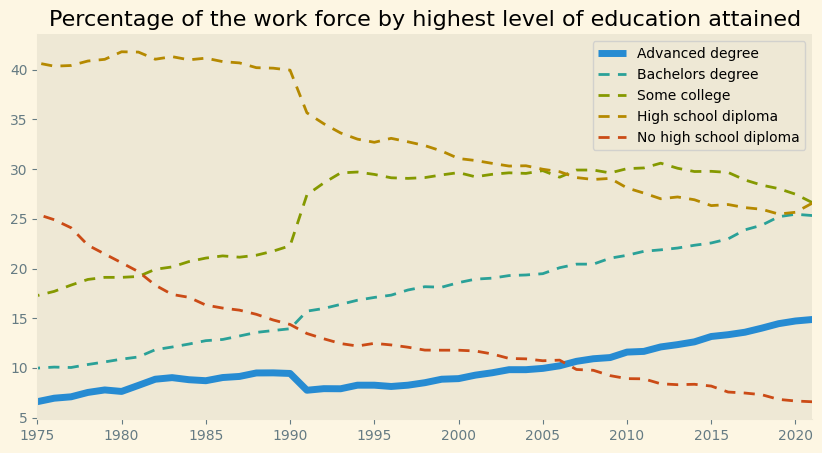

In [41]:
with plt.style.context("Solarize_Light2"):
    fig, ax = plt.subplots(figsize=(10,5))

    # customize line style
    space = 3
    dash_len = 4

    plt.plot(salaries_df['year'], salaries_df['adv_earners_pct'], linestyle='solid', lw=5, label='Advanced degree')
    plt.plot(salaries_df['year'], salaries_df['bachelors_earners_pct'], linestyle='--', dashes=(dash_len, space), label='Bachelors degree')
    plt.plot(salaries_df['year'], salaries_df['some_college_earners_pct'], linestyle='--', dashes=(dash_len, space), label='Some college')
    plt.plot(salaries_df['year'], salaries_df['high_school_earners_pct'], linestyle='--', dashes=(dash_len, space), label='High school diploma')
    plt.plot(salaries_df['year'], salaries_df['no_high_school_earners_pct'], linestyle='--', dashes=(dash_len, space), label='No high school diploma')


    plt.xlim(1975, 2021)
    plt.locator_params(axis='x', nbins=15)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(False)

    plt.title('Percentage of the work force by highest level of education attained')

    plt.legend();

**Advanced Degree:** The line for an advanced degree is one of stable and constant growth over the entire period. The level has been rising from about 5% of the workforce to more than 15% in 2021, which certainly raises a tendency for needing or preferring their prospective employees to be graduates.

**Bachelor Degree:** This line is very much similar to the line of high school graduates, which means growing trends in workers with a bachelor's degree. This category increased by the most percentage, from about 15% in 1975 to just below 40% in 2021.

**Some College:** The rate of some college (but not a degree) increased as a percentage of the total workforce, but the change was not as dramatic as the rates of those with a bachelor's degree. It seems to have hovered between 15-25%, which could suggest that while more have been receiving some form of college education, it hasn't gone up to the level of Bachelor's degrees.

**Workers with a High School Diploma:** The proportion of those workers that have a high school diploma rises from the beginning of the eighties, but then later falls. After mid-1990s, the fall becomes really sharp, likely reflecting an ever-growing demand for higher-educated workers.

**No High School Diploma:** The proportion of the workforce with no more than a high school diploma generally falls from about 35% to about 10%. Generally, this was symptomatic of a declining number of jobs, which would be open to those who had at least not completed high school and likely also signified improvements in the enrollment and completion of secondary education.

In [42]:
edu_counts_df = salaries_df[['year', 'no_high_school_earners', 'high_school_earners','some_college_earners', 'bachelors_earners','adv_earners' ]]
edu_counts_df.head()

,year,no_high_school_earners,high_school_earners,some_college_earners,bachelors_earners,adv_earners
0,2021,10886,43930,44019,41873,24572
1,2020,10985,42240,45240,41910,24236
2,2019,11414,42599,46886,42153,24164
3,2018,12058,42882,46887,40231,23118
4,2017,12240,42816,47382,39153,22277


In [43]:
new_columns = ['year','No high school',
               'High school',
               'Some college',
               'Bachelors degree',
               'Advanced degree']
edu_counts_df.columns = new_columns

In [44]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pd.__version__))

matplotlib: 3.8.3
pandas: 2.2.1


In [45]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

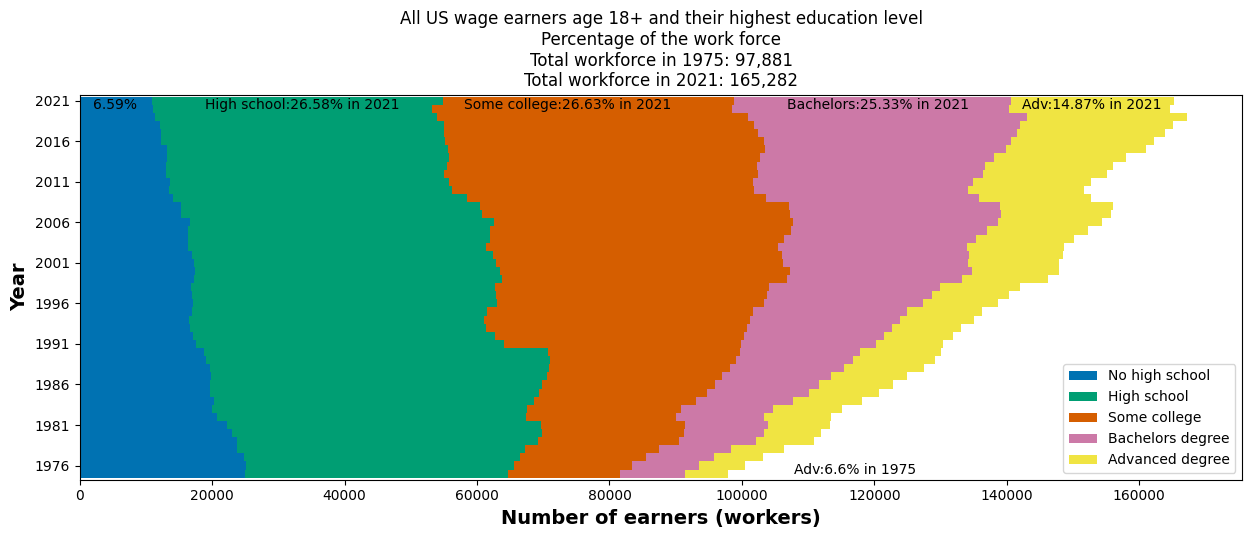

In [46]:
with plt.style.context("seaborn-v0_8-colorblind"):
    ax = edu_counts_df.plot(
    x = 'year',
    kind = 'barh',
    stacked = True,
    title = f"All US wage earners age 18+ and their highest education level\nPercentage of the work force\nTotal workforce in 1975: {salaries_df[salaries_df['year'] == 1975]['total_earners'].iloc[0]:,}" \
        f"\nTotal workforce in 2021: {salaries_df[salaries_df['year'] == 2021]['total_earners'].iloc[0]:,}",
    mark_right = True,
    width=1.0,
    figsize=(15, 5))

    plt.locator_params(axis='y', nbins=10)

    # Invert axis so 2021 is on top. Otherwise 1975 would be on top
    ax.invert_yaxis()

    ax.set_ylabel('Year',
                  fontweight ='bold', fontsize=14)

    ax.set_xlabel('Number of earners (workers)',
                  fontweight ='bold', fontsize=14)

    # ax.get_xaxis().set_major_formatter(
    #     mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Add annotation to where advanced degrees started and ended
    plt.text(salaries_df[salaries_df['year'] == 2021]['total_earners'].iloc[0]-23000, 1,
             f"Adv:{salaries_df[salaries_df['year'] == 2021]['adv_earners_pct'].iloc[0]}% in 2021" , fontsize=10, color='black')
    plt.text(salaries_df[salaries_df['year'] == 2021]['bachelors_earners'].iloc[0]+65000, 1,
             f"Bachelors:{salaries_df[salaries_df['year'] == 2021]['bachelors_earners_pct'].iloc[0]}% in 2021" , fontsize=10, color='black')
    plt.text(salaries_df[salaries_df['year'] == 2021]['some_college_earners'].iloc[0]+14000, 1,
             f"Some college:{salaries_df[salaries_df['year'] == 2021]['some_college_earners_pct'].iloc[0]}% in 2021" , fontsize=10, color='black')
    plt.text(salaries_df[salaries_df['year'] == 2021]['high_school_earners'].iloc[0]-25000, 1,
             f"High school:{salaries_df[salaries_df['year'] == 2021]['high_school_earners_pct'].iloc[0]}% in 2021" , fontsize=10, color='black')
    plt.text(2000, 1,
             f"{salaries_df[salaries_df['year'] == 2021]['no_high_school_earners_pct'].iloc[0]}%" , fontsize=10, color='black')


    # Add 1976 data for Advanced degrees
    plt.text(salaries_df[salaries_df['year'] == 1975]['total_earners'].iloc[0] + 10000, 46,
             f"Adv:{salaries_df[salaries_df['year'] == 1975]['adv_earners_pct'].iloc[0]}% in 1975" , fontsize=10, color='black')

The graph depicts the distribution of education levels within the U.S. workforce over time, using what appears to be a stacked area chart. The chart spans from 1975 to 2021 and illustrates the number of workers (earners) within each education category. Here's what the graph reveals:

**Advanced Degree:**

In 1975, individuals with an advanced degree constituted approximately 6.6% of the workforce. By 2021, this figure has grown to 14.87%, more than doubling over the 46-year period.

**Bachelor's Degree:**

The portion of the workforce with a bachelor's degree has also grown considerably. It stands at 25.33% in 2021, indicating a significant increase, although the graph doesn't provide the exact figure for 1975 for direct comparison.

**Some College:**

Workers with some college education, but no degree, represent 26.63% of the workforce in 2021. This category has seen growth, suggesting a substantial number of people have pursued higher education to some extent.

**High School Diploma:**

The high school diploma category has experienced a relative decline in terms of percentage share of the workforce. It has decreased from being the largest category in 1975 to 26.58% in 2021.

**No High School Diploma:**

There has been a significant reduction in the percentage of the workforce without a high school diploma, from being a substantial portion in 1975 to just 6.59% in 2021. Total Workforce Increase: The total number of workers has grown from 97,881 in 1975 to 165,282 in 2021. This shows overall growth in the workforce, alongside the shifts in educational attainment.

In [47]:


fig = go.Figure()

fig.add_trace(go.Scatter(x=salaries_df['year'], y=salaries_df['total_earners_salary'], mode='lines+markers', name='Total Earners'))
fig.add_trace(go.Scatter(x=salaries_df['year'], y=salaries_df['no_high_school_salary'], mode='lines+markers', name='No High School'))
fig.add_trace(go.Scatter(x=salaries_df['year'], y=salaries_df['high_school_salary'], mode='lines+markers', name='High School'))
fig.add_trace(go.Scatter(x=salaries_df['year'], y=salaries_df['some_college_salary'], mode='lines+markers', name='Some College'))
fig.add_trace(go.Scatter(x=salaries_df['year'], y=salaries_df['bachelors_salary'], mode='lines+markers', name='Bachelors'))
fig.add_trace(go.Scatter(x=salaries_df['year'], y=salaries_df['adv_salary'], mode='lines+markers', name='Advanced Degree'))

fig.update_layout(title='Average Salary Trends by Education Level Over Time',
                  xaxis_title='Year',
                  yaxis_title='Average Salary ($)',
                  legend_title='Education Level',
                  hovermode='x unified')

fig.show()

In [48]:
fig = go.Figure()

fig.add_trace(go.Bar(x=salaries_df['year'], y=salaries_df['no_high_school_salary'], name='No High School'))
fig.add_trace(go.Bar(x=salaries_df['year'], y=salaries_df['high_school_salary'], name='High School'))
fig.add_trace(go.Bar(x=salaries_df['year'], y=salaries_df['some_college_salary'], name='Some College'))
fig.add_trace(go.Bar(x=salaries_df['year'], y=salaries_df['bachelors_salary'], name='Bachelors'))
fig.add_trace(go.Bar(x=salaries_df['year'], y=salaries_df['adv_salary'], name='Advanced Degree'))

fig.update_layout(
    title='Average Salary by Education Level Over Years',
    xaxis_tickangle=-45,
    xaxis_title='Year',
    yaxis_title='Average Salary ($)',
    barmode='group',
    legend_title='Education Level'
)

fig.show()

In [49]:
#!pip install klib

<Axes: xlabel='year', ylabel='Density'>

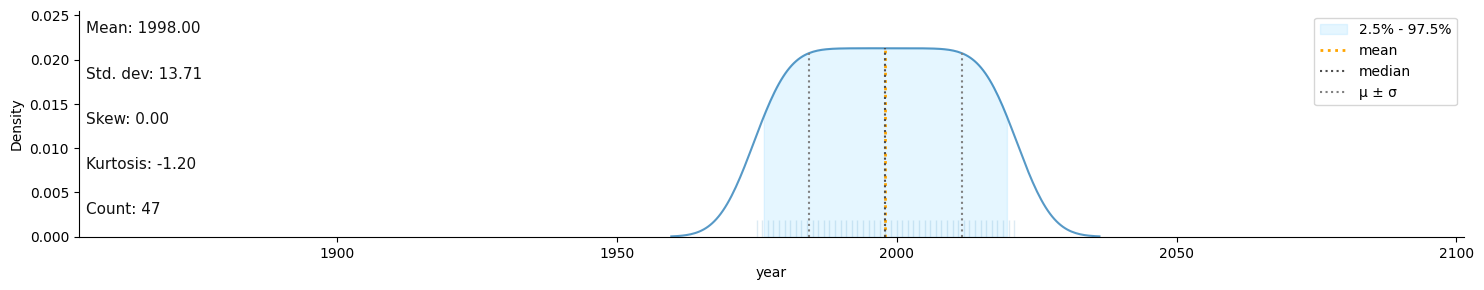

In [50]:
import klib
klib.dist_plot(salaries_df)

This is a kernel density estimate (KDE) plot, one of the ways for estimating the probability density function of a continuous random variable without assuming any parametric form of the density.

Some observations can be derived as follows:

**Mean (Average):** On the plot, the mean (average) year of the data is indicated by the orange dashed vertical line. The mean represents the point at which the data distribution is centered.

**Median:** Represented generally by the yellow dotted vertical line and seems to fall in the same place as the mean, both the median and the mean falling in the same place—i.e., being the same—most of the time suggests that the data is distributed in a symmetrical manner.

**Standard Deviation (Std. dev.):** The difference among 13.71 years for some "spread" or dispersion within the dataset. The "µ ± σ" lines (where µ is the mean and σ is the standard deviation), indicated by the light blue dotted vertical lines at each side of the mean in the plot, represent one standard deviation from the mean. This encompasses the central part of the distribution.

**Skewness:** The skewness is 0.00. This value is sufficient to mention that the data distribution is fairly symmetrical about the mean. In the case of perfect symmetry, the skewness is zero, showing that there is a balance in the tails of the distribution.

**Kurtosis:** A derived measure would, therefore, imply that the data have a flatter peak and thin tails in comparison to the normal distribution, where kurtosis equals zero. This kind of distribution is hence described as platykurtic.

**Count:** There are 47 data points or observations in the dataset. Confidence Interval: This will be the range given as "2.5% - 97.5%", which is likely the 95% confidence interval of data, such that most (95%) of the data should lie within it. Shape of the Distribution: It should be very bell-shaped in the KDE plot since the distribution is symmetric, and the means would be very similar to the medians. The plot would have a very slight lean to the left but is most probably well within what might be considered the range of normal variation.

In [51]:
import plotly.express as px

columns_pairs = [
    ('no_high_school_earners', 'no_high_school_salary'),
    ('high_school_earners', 'high_school_salary'),
    ('some_college_earners', 'some_college_salary'),
    ('bachelors_earners', 'bachelors_salary'),
    ('adv_earners', 'adv_salary')
]

for earners_col, salary_col in columns_pairs:
    fig = px.scatter(salaries_df, x=earners_col, y=salary_col,
                     trendline='ols',
                     title=f'Correlation between Number of Earners and Average Salary ({earners_col.replace("_", " ").title()})')
    fig.show()

We have employed scatter plots which can be used to visually assess the correlations between the number of earners of various education levels and their corresponding average salaries. If there is a correlation, the trend line will help to see whether higher educational attainment is associated with higher average salaries.

In [52]:
import plotly.express as px

year_data = salaries_df[salaries_df['year'] == 2021]

education_levels = ['No High School', 'High School', 'Some College', 'Bachelors', 'Advanced Degree']
earners_counts = [
    year_data['no_high_school_earners'].values[0],
    year_data['high_school_earners'].values[0],
    year_data['some_college_earners'].values[0],
    year_data['bachelors_earners'].values[0],
    year_data['adv_earners'].values[0]
]

fig = px.pie(names=education_levels, values=earners_counts, title='Proportion of Total Earners by Education Level in 2021')

fig.show()

The pie chart, captioned "Proportion of Total Earners by Education Level, 2021," showcases the distribution of earners based on their highest level of educational attainment. Here's a breakdown of what the chart illustrates:

**Some College:** A significant portion of the workforce, at 26.6%, has some college experience. This indicates a notable number of individuals who have pursued higher education to some extent, though not necessarily culminating in a degree.

**High School:** Equally, 26.6% of the workforce has education up to a high school diploma. This underscores that a quarter of the workforce has achieved high school as their highest educational level.

**Bachelors:** Those with a bachelor's degree represent a slightly smaller fraction, at 25.3%, of the workforce. Despite being less than the previously mentioned categories, this still constitutes a substantial segment of the labor force.

**Advanced Degree:** Individuals possessing an advanced degree, such as master's, professional, or doctoral degrees, account for 14.9% of the workforce. This highlights that while higher-level qualifications are less common compared to undergraduate accomplishments, they nonetheless represent a significant share.

**No High School:** The smallest group, at 6.59%, comprises those within the workforce without a high school diploma, signaling that the vast majority of workers have attained at least a high school level of education or higher.

In [53]:
import plotly.express as px

salary_columns = [
    'total_earners_salary',
    'no_high_school_salary',
    'high_school_salary',
    'some_college_salary',
    'bachelors_salary',
    'adv_salary'
]

for column in salary_columns:
    fig = px.histogram(salaries_df, x=column, nbins=20, title=f'Distribution of {column.replace("_", " ").title()}')
    fig.show()

This is a series of histograms, each providing a visual representation of how salaries are distributed within different categories of earners in your dataset, such as "Total Earners Salary," "No High School Salary," "High School Salary," "Some College Salary," "Bachelors Salary," and "Adv Salary."

Plotly's interactive histograms will also allow users to interact with the plot to zoom in and out, hover over bins to see counts or densities, and pan across the distribution. The histograms will help in understanding the spread, central tendency, and skewness of salary distributions for different educational levels.

In [54]:
salaries_df.head()

,year,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary,no_high_school_earners_pct,high_school_earners_pct,some_college_earners_pct,bachelors_earners_pct,adv_earners_pct
0,2021,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600,6.59,26.58,26.63,25.33,14.87
1,2020,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833,6.67,25.66,27.48,25.46,14.72
2,2019,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766,6.83,25.48,28.04,25.21,14.45
3,2018,165179,64340,12058,31870,42882,38936,46887,43053,40231,71155,23118,99919,7.30,25.96,28.39,24.36,14.00
4,2017,163871,74320,12240,36980,42816,38145,47382,41507,39153,67763,22277,98369,7.47,26.13,28.91,23.89,13.59


In [55]:
import plotly.express as px

column_pairs = [
    ('no_high_school_earners', 'no_high_school_salary'),
    ('high_school_earners', 'high_school_salary'),
    ('some_college_earners', 'some_college_salary'),
    ('bachelors_earners', 'bachelors_salary'),
    ('adv_earners', 'adv_salary')
]

for earners_col, salary_col in column_pairs:
    fig = px.scatter(salaries_df, x=earners_col, y=salary_col, trendline="ols",
                     title=f"Regression Plot: {earners_col.replace('_', ' ').title()} vs. {salary_col.replace('_', ' ').title()}")
    fig.show()

In [56]:
import plotly.express as px

salary_columns = [
    'no_high_school_salary',
    'high_school_salary',
    'some_college_salary',
    'bachelors_salary',
    'adv_salary'
]

for column in salary_columns:
    fig = px.strip(salaries_df, x="year", y=column, title=f"Strip Plot of {column.replace('_', ' ').capitalize()} Over Years")
    fig.show()

we can observe the distribution and range of salaries within each educational category across different years.

In [57]:
import plotly.express as px

salary_columns = [
    'no_high_school_salary',
    'high_school_salary',
    'some_college_salary',
    'bachelors_salary',
    'adv_salary'
]

for column in salary_columns:
    fig = px.box(salaries_df, y=column,
                 title=f"Salary Distribution: {column.replace('_', ' ').title()}")
    fig.show()

The salary distributions: We can observe that all the box plots appear like same, so there is a uniform distribution spread of salaries for different categories of education with the same breadth, equally spread on both sides from the median.

Outliers: The outliers among the salary data are taken to be those that are very high or low, such that they do not fall between the normally experienced spread of characteristic salaries. But here the boxplot has no outliers, it means there are very few to no extreme salary values that deviate too far from the rest.

Median and Mean: we can also observe that the median line does not coincide along the center of the box, this would imply the data is skewed. A median coinciding with the center line, as shown in the plot, shows symmetry; this means that there is an equal spread of salaries above the median in that category of education.

Consistency between education levels: All the plots that this code gives are similar, it would be quite a finding, since this might mean the range and distribution of salaries do not change much according to changes in education level. Quite an unexpected result if this were to be the case. Normally, a relationship between higher levels of education and higher median values of the salary will exist. Similarly, wider ranges of salaries can also be expected to exist due to higher possibilities for the existence of very high salaries.

In [58]:
import plotly.figure_factory as ff

corr_matrix = salaries_df.corr()
fig = ff.create_annotated_heatmap(
    z=corr_matrix.to_numpy(),
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.columns.tolist(),
    annotation_text=corr_matrix.round(2).to_numpy(),
    colorscale="Viridis",
    showscale=True
)

fig.show()

Key observations from the heatmap:

**Strong Positive Correlations:**

Equally, in the same category of education (e.g., 'bachelors_earners' with 'bachelors_salary'), one will notice strong positive associations close to 1 between the number of earners and average salary. This indicates if the number of "bachelors" earners increases, then the average salary for the category of "bachelors" earners also increases.
Likewise, earners across most education levels are highly positively correlated with each other (e.g., some_college_earners to bachelors_earners), suggesting that increases or decreases in the number of earners occur simultaneously across almost all these categories.

**Negative Correlations with 'year':**

The variable "year" has a negative correlation with "no high school earners" and "no high school salary," implying a decrease over the years in both the number and salaries of workers without a high school diploma.

**Other Notable Correlations:**

'Total_earners_salary' shows a moderately strong positive correlation with salaries at three different education levels, indicating that with a high average salary at a specific education level, the overall average salary also tends to be high.
'Total_earners' is inversely related to 'no_high_school_earners' but positively related to higher categories of education, suggesting a changing composition of the workforce over time towards more attainment levels of education.

**Diagonal Values:**

The diagonal of the heatmap is where each variable is correlated with itself, hence the perfect correlation score of 1.
Darker Colors for Negative Correlations:

Darker shades (probably purple or blue) in the heatmap indicate negative correlations, as seen in the correlation of 'year' with 'no_high_school_earners' and 'no_high_school_salary'.
Brighter Colors for Positive Correlations:

The lighter shades (probably yellow or green) most clearly represent the positive correlations, especially in those blocks where the correlations are very strong (close to 1).

<hr>

# Export clean data

In [59]:
import pandas as pd
file_path = 'data/salary_both_genders_clean.csv'
salaries_df = pd.read_csv(file_path, index_col='year', parse_dates=['year'])
salaries_df.head()

,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
year,,,,,,,,,,,,
2021-01-01,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
2020-01-01,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
2019-01-01,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766
2018-01-01,165179,64340,12058,31870,42882,38936,46887,43053,40231,71155,23118,99919
2017-01-01,163871,74320,12240,36980,42816,38145,47382,41507,39153,67763,22277,98369


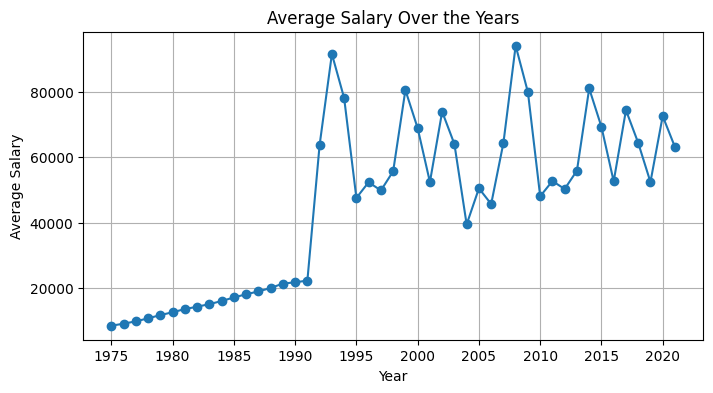

In [60]:
plt.figure(figsize=(8,4))
plt.xlabel("Year")
plt.ylabel("Average Salary")
plt.plot(salaries_df.index, salaries_df['total_earners_salary'], marker='o')
plt.title("Average Salary Over the Years")
plt.grid(True)
plt.show()

- As we know that, A stationary Time Series is one which characteristics like mean and variance does not change over time

- Preparing the data for analyzing the Rolling Mean and Standard Deviation to check stationarity for given Time Series

### Description of Time series

- Calculating Rolling mean and Standard deviation for 5 Years.

In [61]:
rolmean = salaries_df['total_earners_salary'].rolling(window=5).mean()
rolstd = salaries_df['total_earners_salary'].rolling(window=5).std()

# print(salaries_df['total_earners_salary'].head(15))
# print()
# print(rolmean.head(15))
# print()
# print(rolstd.head(15))

- Plotting the Rolling Mean and Standard Deviation, which has window of 5
- By looking below plot, we conclude that, it is non-stationary bcoz mean and variance is not constant

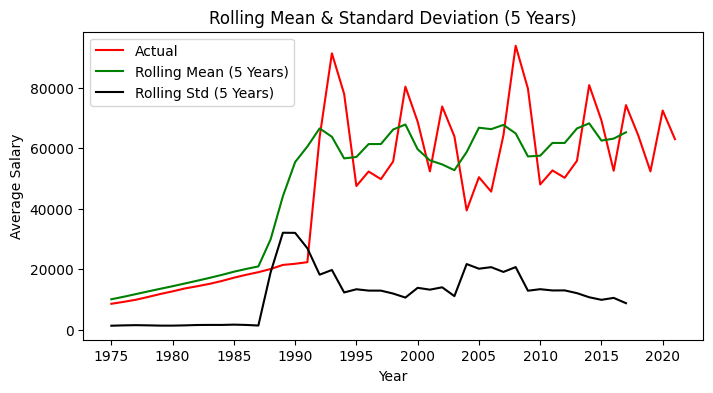

In [62]:
plt.figure(figsize=(8,4))
actual = plt.plot(salaries_df.index, salaries_df['total_earners_salary'], color='red', label='Actual')
mean_5 = plt.plot(rolmean, color='green', label='Rolling Mean (5 Years)')
std_5 = plt.plot(rolstd, color='black', label='Rolling Std (5 Years)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (5 Years)')
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.show(block=False)

- Using ADF (Augmented Dickey-Fuller Test) to check stationarity, another approach based on statistics.
- ADF has: <b> Null hypothesis - Time Series is non-stationary

In [63]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
sal_test=adfuller(salaries_df['total_earners_salary'], autolag='AIC')
sal_output=pd.Series(sal_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in sal_test[4].items():
    sal_output['Critical Value (%s)'%key] = value
print(sal_output)

Dickey-Fuller Test: 
Test Statistic                  0.223868
p-value                         0.973569
Lags Used                       7.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


# **Decomposition before transformation of TS Data**

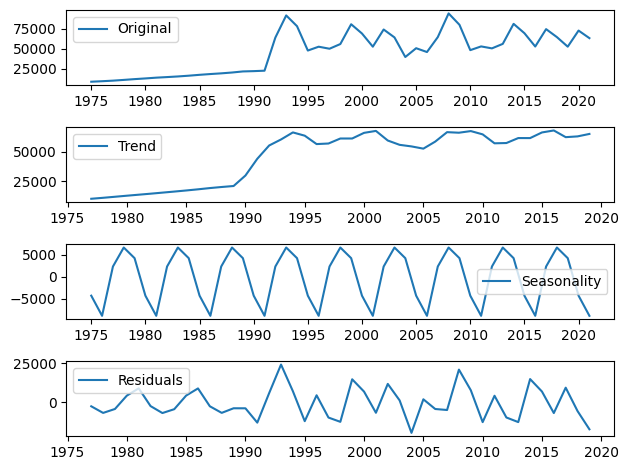

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(salaries_df['total_earners_salary'], model='additive', period=5)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid
residual.dropna(inplace=True)

plt.subplot(411)
plt.plot(salaries_df['total_earners_salary'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**Original Series:**

This is the actual time series data. There are clear, regular oscillations suggesting seasonality. The magnitude of the seasonal fluctuations appears relatively constant over time. There are no obvious long-term trends or changes in variance over time in this plot.

**Trend Component:**

This shows the long-term progression of the data. It suggests a relatively stable level until the early 1980s. Early 1980s have always shown a consistent increase over time, suggesting a positive trend in the underlying data until plateaus again by around 2005. After 2005, the trend undulates with minor dips and waves but stays moderately flat, showing no significant long-term change since that point.

**Seasonality Component:**

This reveals the seasonal pattern within the data. The seasonality is quite regular and pronounced, with peaks and troughs occurring at consistent intervals. This pattern repeats itself at what appears to be yearly intervals, suggesting an annual seasonality.

**Residuals Component:**

These are the irregularities that remain after the trend and seasonal components are removed from the original series. Residuals should ideally look like white noise, meaning they should show no discernible patterns. The residuals from this series fluctuate, but in a manner with no discernible pattern. This would imply that the model explains most of the structure really residing within the data but not captured in its totality, even though there may be some unexplained volatility.

**Summary:** The time series starts off with a slow increasing trend before fluctuating consistently with peaks and troughs occurring on a regular basis. This points to a long-term rise in the series' average level with consistent variations. These oscillations, which show yearly seasonality and happen at regular intervals, are probably caused by recurrent elements like seasonal trends or outside events. Longer term patterns spanning several years may also be influenced by less predictable cyclicality. Variability is seen throughout the series, with variations near the trendline perhaps resulting from chance or outside factors. For modeling and forecasting to be effective, it is necessary to comprehend these characteristics, which include trend, seasonality, cyclicality, and variability. This allows us to identify and use the right analytical techniques to capture and account for the underlying patterns in the data.

Analysis:
- From the above ADF test, we fail to reject the null hypothesis, since the p-value is greater than 0.05
- <b>This Dataset is Not Stationary in nature</b>

<hr>

### Transformation of Data to make it stationary for Time Series Analysis

- Below we took log transformation to make our Time series stationary and plotted a visual for it.
- We found the graph upward trending over time with no seasonality

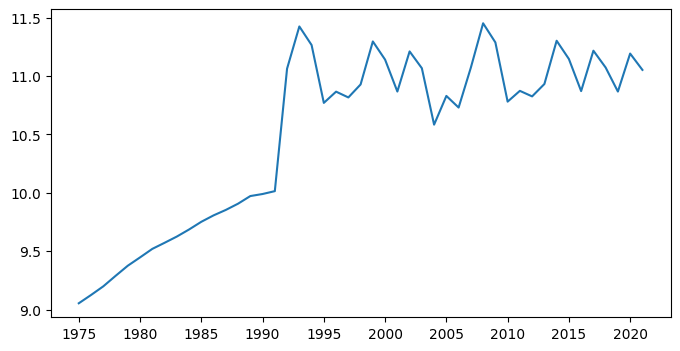

In [65]:
plt.figure(figsize=(8,4))
sal_data_log=np.log(salaries_df['total_earners_salary'])
plt.plot(salaries_df.index, sal_data_log)

- Testing Rolling Mean with window 5 on above log transformation and concluded non-stationary, again

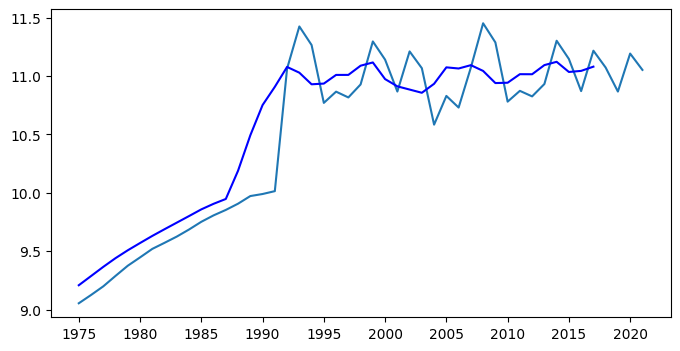

In [66]:
plt.figure(figsize=(8,4))
MAvg_sal=sal_data_log.rolling(window=5).mean()
MStd_sal=sal_data_log.rolling(window=5).std()
plt.plot(sal_data_log)
plt.plot(MAvg_sal, color='blue')

In [67]:
sal_data_log.index = pd.to_datetime(sal_data_log.index, format='%Y')
sal_data_log = sal_data_log.asfreq('AS-JAN')
sal_data_log.dropna(inplace=True)
#print(sal_data_log)

C:\Users\pdmil\AppData\Local\Temp\ipykernel_28064\3256225793.py:2: FutureWarning:

'AS-JAN' is deprecated and will be removed in a future version, please use 'YS-JAN' instead.



- Using another method differencing, to make our time series stationary


In [68]:
sal_log_diff=sal_data_log-MAvg_sal
sal_log_diff.head(12)

year
1975-01-01   -0.154384
1976-01-01   -0.162057
1977-01-01   -0.166825
1978-01-01   -0.151909
1979-01-01   -0.132187
1980-01-01   -0.123038
1981-01-01   -0.111039
1982-01-01   -0.116409
1983-01-01   -0.119379
1984-01-01   -0.115075
1985-01-01   -0.106290
1986-01-01   -0.099036
Freq: YS-JAN, Name: total_earners_salary, dtype: float64

- Output of differencing method, after dropping null values

In [69]:
sal_log_diff=sal_log_diff.dropna()
sal_log_diff.head()

year
1975-01-01   -0.154384
1976-01-01   -0.162057
1977-01-01   -0.166825
1978-01-01   -0.151909
1979-01-01   -0.132187
Freq: YS-JAN, Name: total_earners_salary, dtype: float64

- Defining function for Rolling Mean and Standard Deviation & ADF test


In [70]:
def check_stationarity(earnings_series):

    rolling_mean=earnings_series.rolling(window=5).mean()
    rolling_std=earnings_series.rolling(window=5).std()

    plt.figure(figsize=(8,4))
    orig=plt.plot(earnings_series, color='red', label='Original')
    mean=plt.plot(rolling_mean, color='green', label='Rolling Mean')
    std=plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Dickey-Fuller Test: ')
    test_result=adfuller(earnings_series, autolag='AIC')
    test_output=pd.Series(test_result[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in test_result[4].items():
        test_output['Critical Value (%s)'%key] = value
    print(test_output)

- Checking the stationarity of differenced data
- From Rolling method, we see that Mean and standard deviation is not varying.
- From ADF, we reject the null hypothesis bcoz p-value is less than 0.05 (significance level)
- Applying all the transformation and methods, our differenced data is now stationary

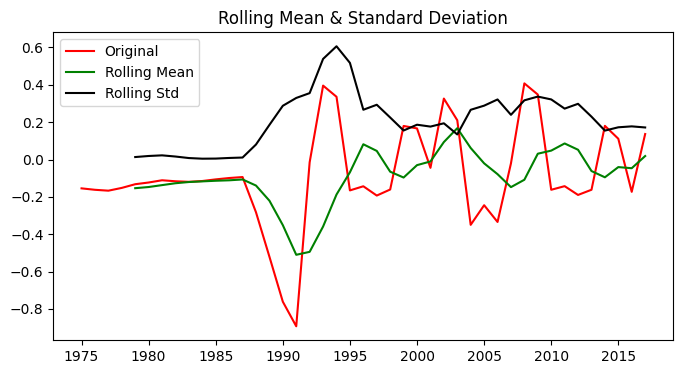

Dickey-Fuller Test: 
Test Statistic                 -4.779987
p-value                         0.000059
Lags Used                       1.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [71]:
check_stationarity(sal_log_diff)

- Checking for Trend stationarity and performing exponential transformation on our data


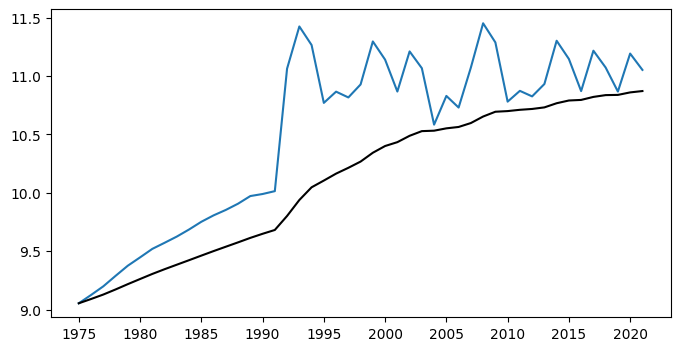

In [72]:
plt.figure(figsize=(8,4))
exp_sal_data=sal_data_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(sal_data_log)
plt.plot(exp_sal_data, color='black')

- Since log transformation is non-stationary, applying differencing on our data.

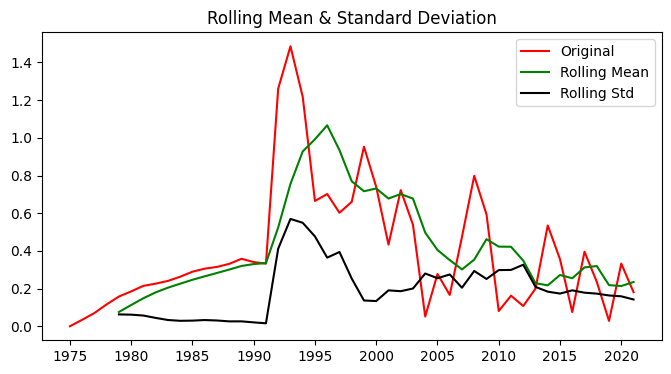

Dickey-Fuller Test: 
Test Statistic                 -2.869023
p-value                         0.049071
Lags Used                       0.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [73]:
exp_sal_diff=sal_data_log-exp_sal_data
check_stationarity(exp_sal_diff)

- From above graph and ADF test, we conclude, it is trend stationary
- P-value is less than 0.05: <b> Trend is stationary now

<hr>

- Eliminating Trend and Seasonality

#### Differencing:

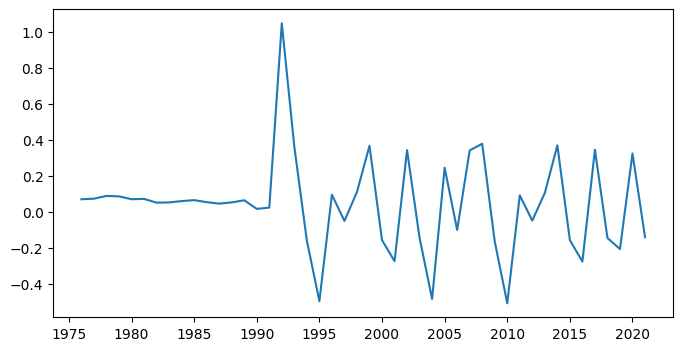

In [74]:
plt.figure(figsize=(8,4))
sal_data_shift=sal_data_log-sal_data_log.shift()
plt.plot(sal_data_shift)

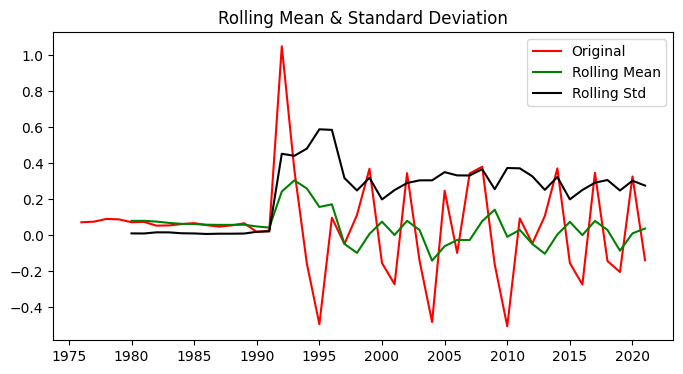

Dickey-Fuller Test: 
Test Statistic                 -5.014683
p-value                         0.000021
Lags Used                       3.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64


In [75]:
sal_data_shift=sal_data_shift.dropna()
check_stationarity(sal_data_shift)

<hr>

#### Decomposition:

- Decomposing Time Series into its components: Trend, Seasonality and Residual


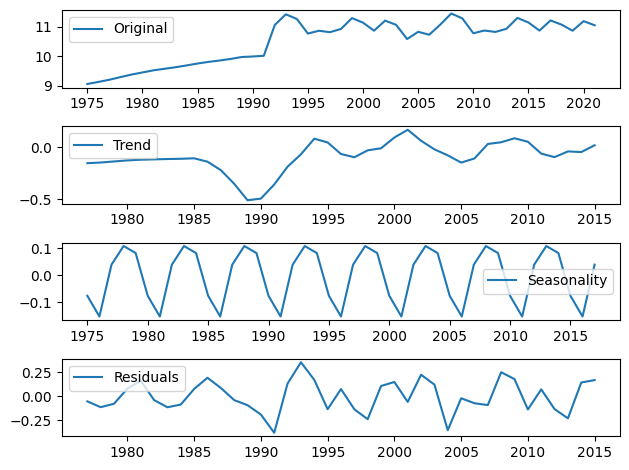

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(sal_log_diff, model='additive', period=5)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid
residual.dropna(inplace=True)

plt.subplot(411)
plt.plot(sal_data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**Original Series (Transformed):**

In fact, the relatively flat line reflects no clear upward or downward trends and can also be a possibility that it actually detrended the stabilized series which were originally transformed. The values fluctuate around a certain level, which seems to have some irregular cycles or variations in amplitude.

**Trend Component:**

The trend component shows some long-term variability but no strong directional trend. It, therefore, suggests periods of slight increase and decrease over a number of years, probably indicating some cyclical behavior in the underlying trend of the data.

**Seasonality Component:**

Indeed, it has been noted that there is a clear and emphatic seasonal pattern, with regularly spaced peaks and troughs that appear to be of fairly consistent frequency and magnitude. The regularity of this pattern indicates a strong seasonal influence, which seems to have a fixed period.

**Residuals Component:**

The remaining residuals—that is, the estimation noise or random fluctuations that are left after the trend and seasonal components have been factored out—seem to contain some structure in the shape of periods of relatively high or low volatility. Spikes are somewhat apparent over this period, reflecting some of the relatively rare fluctuations in the non-sample elements of the pattern captured by the trend and seasonals.


**Summary:** This original series (after transformation) suggests that the data has been made stationary with respect to mean, and possibly the variance; and hence, the data rendered more appropriate for modeling with linear time series methods. This cyclical behavior in the trend component puts forth that there might be some underlying cause or causes spanning many years and that could be either the influence of an economic or business cycle if this is financial or economic data. The strong seasonality requires seasonality to be accounted for in any predictive modeling. The residuals do not appear as pure noise and refer to some model-inherent processes which might not be captured in the model used during the decomposition of the data. It may also be of value to note the residuals for any further patterns or information that may be modeled.

- Checking the stationarity of Time Series components

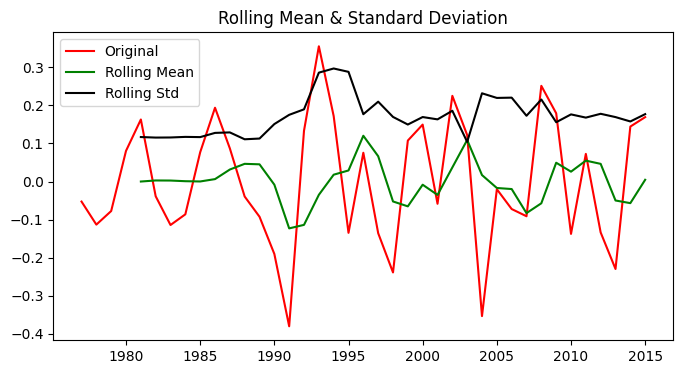

Dickey-Fuller Test: 
Test Statistic                -6.706947e+00
p-value                        3.764179e-09
Lags Used                      4.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64


In [77]:
sal_log_decompose = residual
sal_log_decompose.dropna(inplace=True)
check_stationarity(sal_log_decompose)

# **TS models &  Predictions**

## **Final Forecasting**

### ACF & PACF Plots

- Plotting the ACF and PACF to find q and p values.
- We got q and p both 2 from the graph

Text(0.5, 1.0, 'Partial Autocorrelation Function')

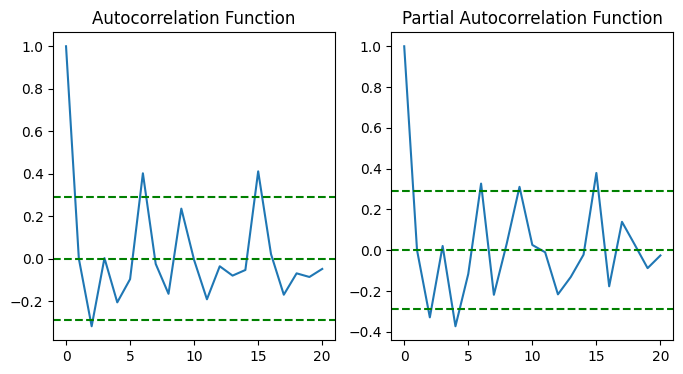

In [78]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(sal_data_shift, nlags=20)
lag_pacf=pacf(sal_data_shift, nlags=20, method='ols')

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(sal_data_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(sal_data_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(sal_data_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(sal_data_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

- The values where it first hits off 0 are the corresponding P and Q.
- P (AR (p) PACF ) lags at 2 and Q (MA (q)  ACF ) also lags at 2

In [79]:
#!pip install pmdarima

# AR Model - Auto Regression

plotting AR model


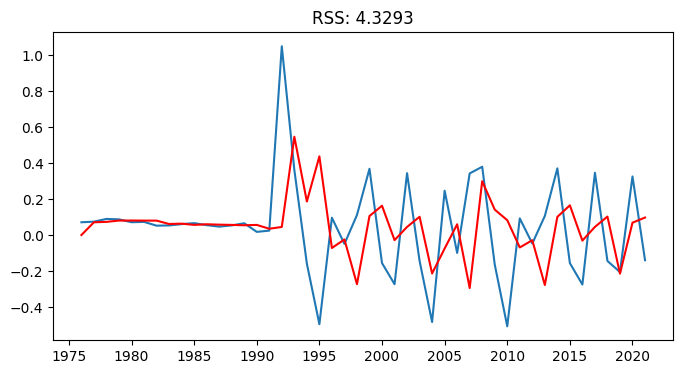

In [80]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(8,4))
model=ARIMA(sal_data_shift, order=(2,1,0))
results=model.fit()
plt.plot(sal_data_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-sal_data_shift)**2))
print('plotting AR model')

In [81]:
import pickle
with open('models/AR.pkl', 'wb') as f:
    pickle.dump(model, f)

# MA Model - Moving Average

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



plotting MA model


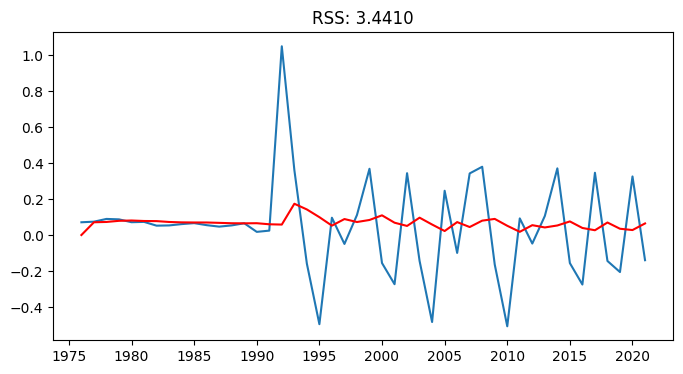

In [82]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(8,4))
model=ARIMA(sal_data_shift, order=(0,1,2))
results=model.fit()
plt.plot(sal_data_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-sal_data_shift)**2))
print('plotting MA model')

In [83]:
with open('models/MA.pkl', 'wb') as f:
    pickle.dump(model, f)

# ARIMA Model

- Building the ARIMA model with p=2, q=2 and I=1

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



plotting ARIMA model


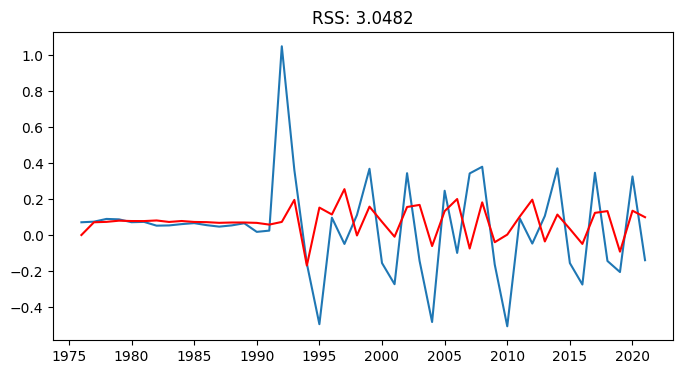

In [84]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(8,4))
model=ARIMA(sal_data_shift, order=(2,1,2))
results=model.fit()
plt.plot(sal_data_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-sal_data_shift)**2))
print('plotting ARIMA model')

In [85]:
with open('models/ARIMA.pkl', 'wb') as f:
    pickle.dump(model, f)

- Predicted values from ARIMA model in difference form

In [86]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

year
1976-01-01    0.000000
1977-01-01    0.070862
1978-01-01    0.073071
1979-01-01    0.079715
1980-01-01    0.077695
Freq: YS-JAN, dtype: float64


- Performing Inverse Transformation for differencing, by doing cumulative sum

In [87]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

year
1976-01-01    0.000000
1977-01-01    0.070862
1978-01-01    0.143933
1979-01-01    0.223648
1980-01-01    0.301343
Freq: YS-JAN, dtype: float64


In [88]:
sal_data_shift.iloc[0]

0.07086203090965526

- Below is data display of predicted value in log scale

In [89]:
predictions_log=pd.Series(sal_data_shift.iloc[0], index=sal_data_shift.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

year
1976-01-01    0.070862
1977-01-01    0.141724
1978-01-01    0.214795
1979-01-01    0.294510
1980-01-01    0.372205
Freq: YS-JAN, dtype: float64

- Plotting the visual for forecast of next 10 years with 95% confidence interval

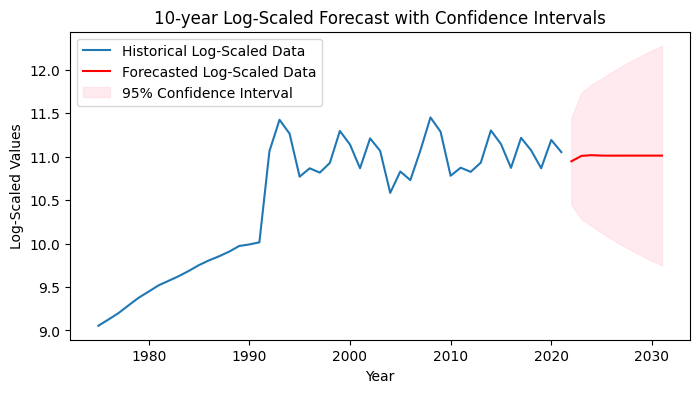

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sal_data_log, order=(2, 1, 2))
results = model.fit()

forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=sal_data_log.index[-1], periods=forecast_steps + 1, freq='YS')[1:]
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(8,4))
plt.plot(sal_data_log.index, sal_data_log, label='Historical Log-Scaled Data')
plt.plot(forecast_index, forecast_mean, label='Forecasted Log-Scaled Data', color='red')

plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('10-year Log-Scaled Forecast with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Log-Scaled Values')
plt.legend(loc='upper left')
plt.show()

# Hyperparameter tunning to find optimal ARIMA Parameter

In [91]:
import pmdarima as pm

auto_model = pm.auto_arima(sal_log_decompose, seasonal=True, m=5,
                           trace=True, error_action='ignore',
                           suppress_warnings=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=-52.244, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-25.404, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-27.333, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-40.975, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-27.403, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[5] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,2)(1,0,0)[5] intercept   : AIC=-44.560, Time=0.23 sec
 ARIMA(2,0,2)(2,0,1)[5] intercept   : AIC=-52.529, Time=0.44 sec
 ARIMA(2,0,2)(2,0,0)[5] intercept   : AIC=-53.729, Time=0.33 sec
 ARIMA(1,0,2)(2,0,0)[5] intercept   : AIC=-53.764, Time=0.29 sec
 ARIMA(1,0,2)(1,0,0)[5] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,2)(2,0,1)[5] intercept   : AIC=-51.627, Time=0.32 sec
 ARIMA(1,0,2)(1,0,1)[5] intercept   : AIC=-49.468, Time=0.28 sec
 ARIMA(0,0,2)(2,0,0)[5] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(2,0,0)[5] intercept   : AIC=-44.289, Time=0.1

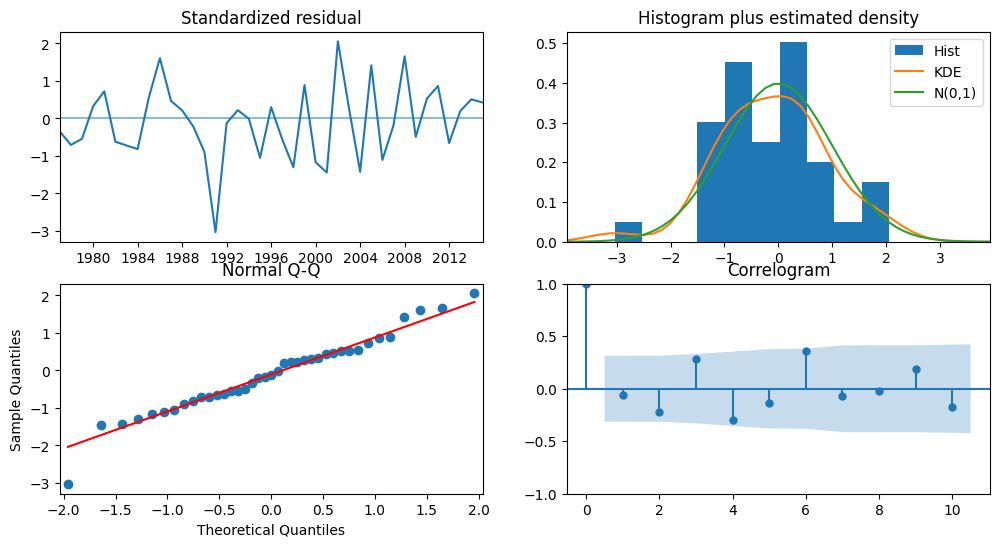

In [92]:
auto_model.plot_diagnostics(figsize=(12, 6))
plt.show()

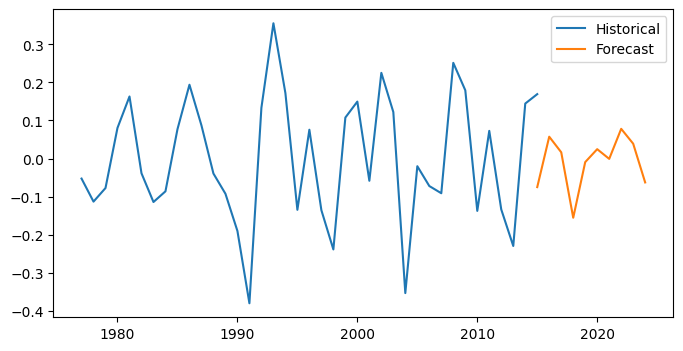

In [93]:
forecast = auto_model.predict(n_periods=10)

plt.figure(figsize=(8,4))
plt.plot(sal_log_decompose.index, sal_log_decompose, label='Historical')
plt.plot(pd.date_range(sal_log_decompose.index[-1], periods=10, freq='YS'), forecast, label='Forecast')
plt.legend()
plt.show()

# SARIMAX Model

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



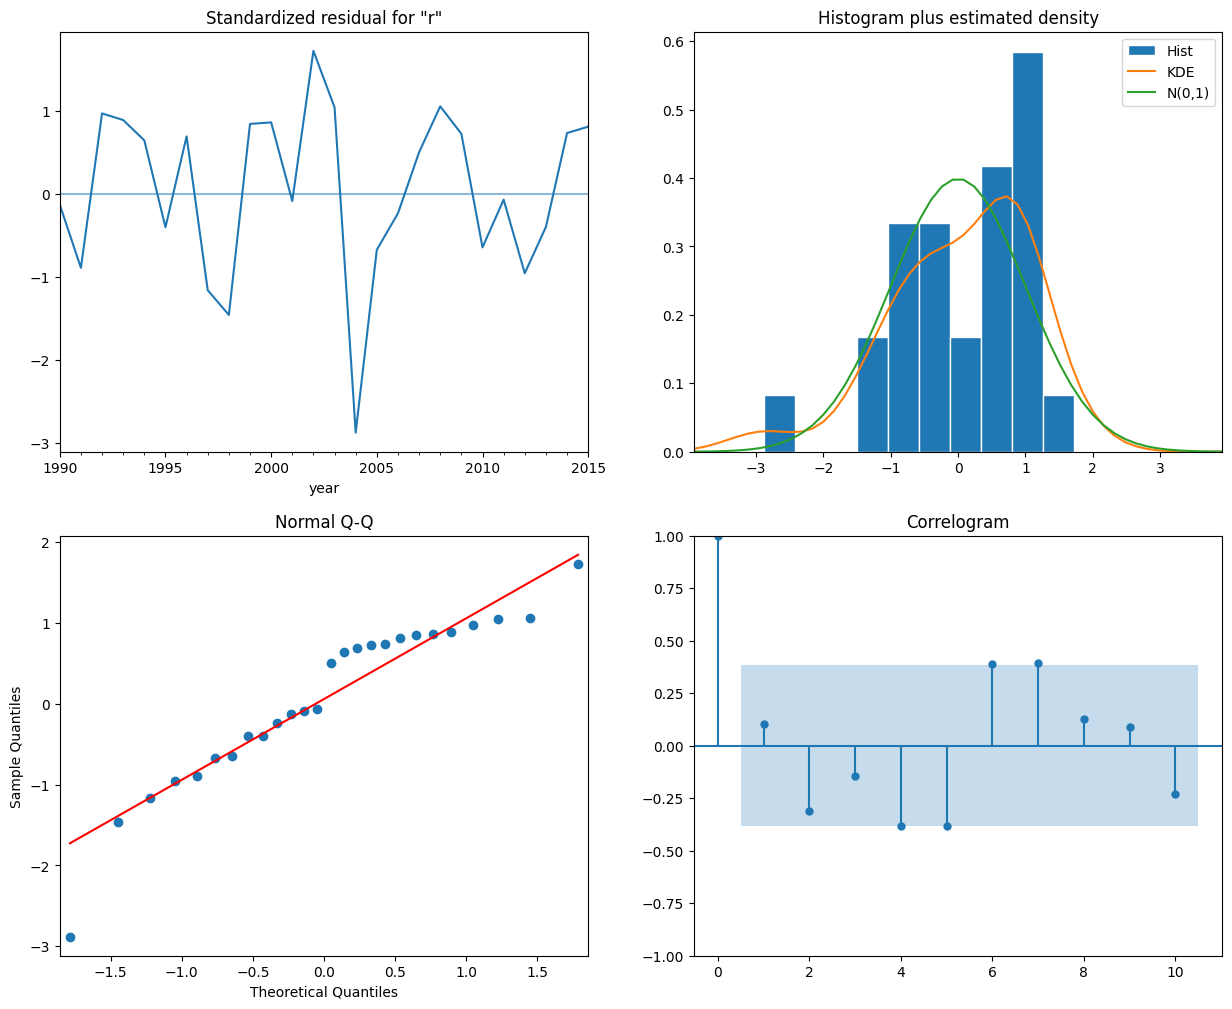

RSS for sarimax model= 1.5690883979533625


In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(sal_log_decompose, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_results = sarimax_model.fit()
sarimax_results.plot_diagnostics(figsize=(15, 12))
plt.show()
sarimax_forecast = sarimax_results.forecast(steps=12)

residuals = sarimax_results.resid
rss = (residuals ** 2).sum()
print('RSS for sarimax model=', rss)

In [95]:
with open('models/SARIMA.pkl', 'wb') as f:
    pickle.dump(sarimax_model, f)

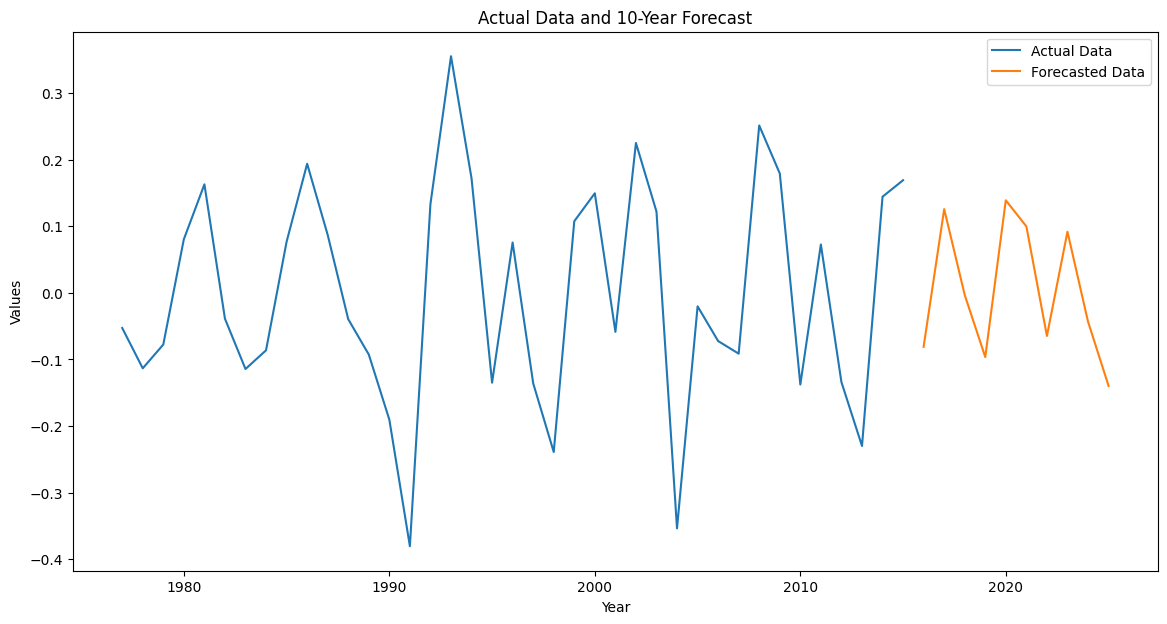

In [96]:
forecast_years = 10
sarimax_forecast = sarimax_results.forecast(steps=forecast_years)

last_year = sal_log_decompose.index[-1].year
forecast_index = pd.date_range(start=pd.Timestamp(year=last_year + 1, month=1, day=1), periods=forecast_years, freq='YS')
plt.figure(figsize=(14, 7))
plt.plot(sal_log_decompose.index, sal_log_decompose, label='Actual Data')
plt.plot(forecast_index, sarimax_forecast, label='Forecasted Data', linestyle='-')
plt.title('Actual Data and 10-Year Forecast')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.show()

# LSTM Model

ADF Statistic: -1.622611
p-value: 0.471361
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608

After Differencing:
ADF Statistic: -3.941886
p-value: 0.001747
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



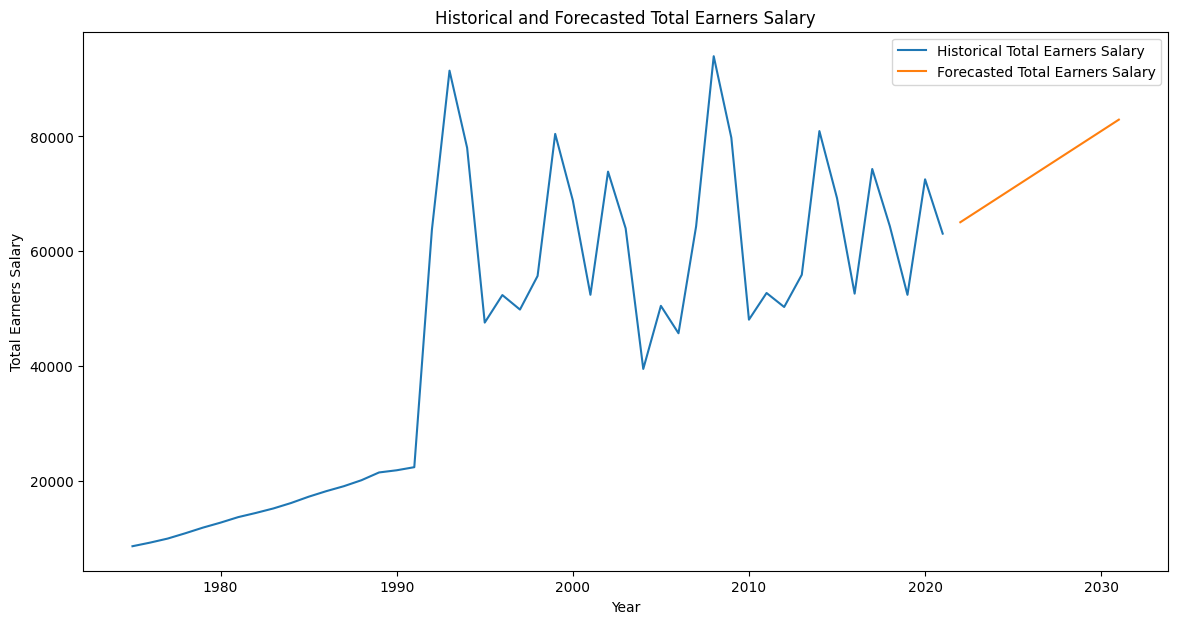

In [98]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
 
df = pd.read_csv('data/salary_both_genders_clean.csv')

df.sort_values("year", inplace=True)

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

check_stationarity(df['total_earners_salary'])

df['salary_diff'] = df['total_earners_salary'].diff().dropna()

print("\nAfter Differencing:")
check_stationarity(df['salary_diff'].dropna())

x = df[['year']].iloc[1:]
y = df['salary_diff'].dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)
x_scaled = x_scaled.reshape((x_scaled.shape[0], 1, x_scaled.shape[1]))

tss = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tss.split(x_scaled):
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, x_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=100, verbose=0)

y_pred = model.predict(x_test, verbose=0)

last_year = df['year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 11).reshape(-1, 1)

future_years_scaled = scaler.transform(future_years)
future_years_scaled = future_years_scaled.reshape((future_years_scaled.shape[0], 1, 1))

predicted_diff = model.predict(future_years_scaled, verbose=0)

predicted_diff_rescaled = scaler.inverse_transform(predicted_diff)

last_known_salary = df['total_earners_salary'].iloc[-1]
predicted_salaries = [last_known_salary + np.cumsum(predicted_diff_rescaled.flatten())]

predicted_salaries = np.array(predicted_salaries).flatten()

all_years = np.concatenate([df['year'], future_years.flatten()])

plt.figure(figsize=(14, 7))
plt.plot(df['year'], df['total_earners_salary'], label='Historical Total Earners Salary')
plt.plot(all_years[-10:], predicted_salaries, label='Forecasted Total Earners Salary', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Earners Salary')
plt.title('Historical and Forecasted Total Earners Salary')
plt.legend()
plt.show()

In [ ]:
# with open('models/LSTM.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [99]:
from sklearn.metrics import mean_squared_error

residuals = y_test - y_pred.flatten()
mse = mean_squared_error(y_test, y_pred.flatten())
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 14493.480334170314


# Naive Model

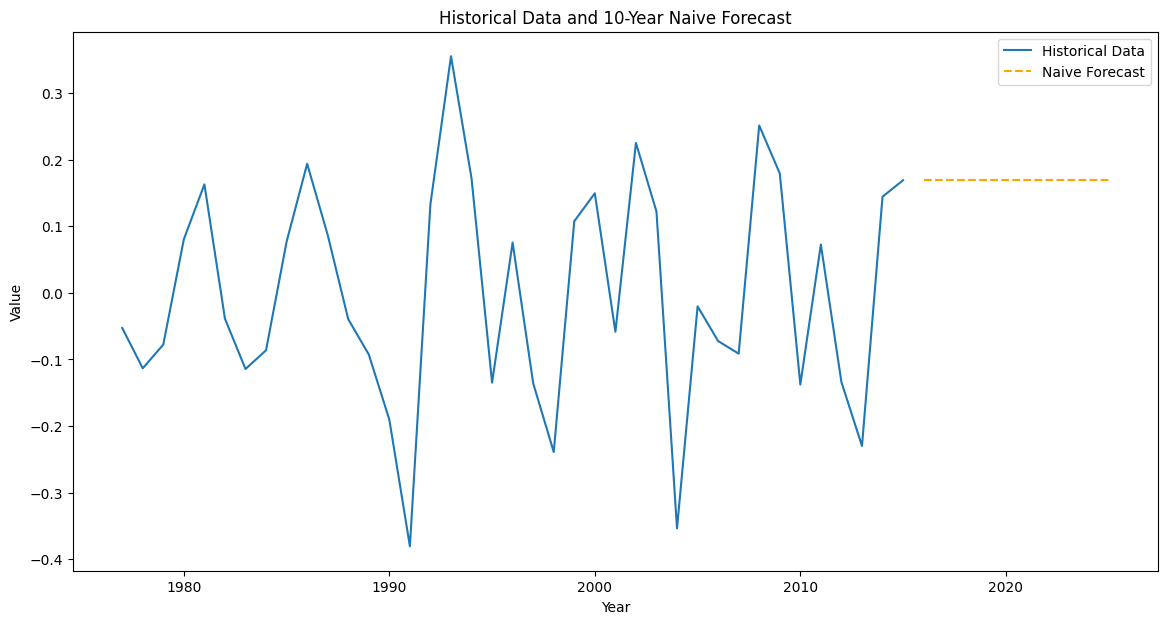

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def naive_forecast(series, steps):
    return np.array([series.iloc[-1]] * steps)

forecast_years = 10
naive_forecast_values = naive_forecast(sal_log_decompose, forecast_years)

last_year = sal_log_decompose.index[-1].year
forecast_index = pd.date_range(start=pd.Timestamp(year=last_year + 1, month=1, day=1), periods=forecast_years, freq='YS')

plt.figure(figsize=(14, 7))
plt.plot(sal_log_decompose.index, sal_log_decompose, label='Historical Data')
plt.plot(forecast_index, naive_forecast_values, label='Naive Forecast', linestyle='--', color='orange')
plt.title('Historical Data and 10-Year Naive Forecast')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [101]:
# Calculate residuals
residuals = sal_log_decompose.values.flatten()[-forecast_years:] - naive_forecast_values

# Calculate Residual Sum of Squares (RSS)
rss = np.sum(residuals**2)
print('RSS:', rss)

RSS: 0.4883793347087812


# MLP Model

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

D:\IndianaU\DSCI-Time-Series\env\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



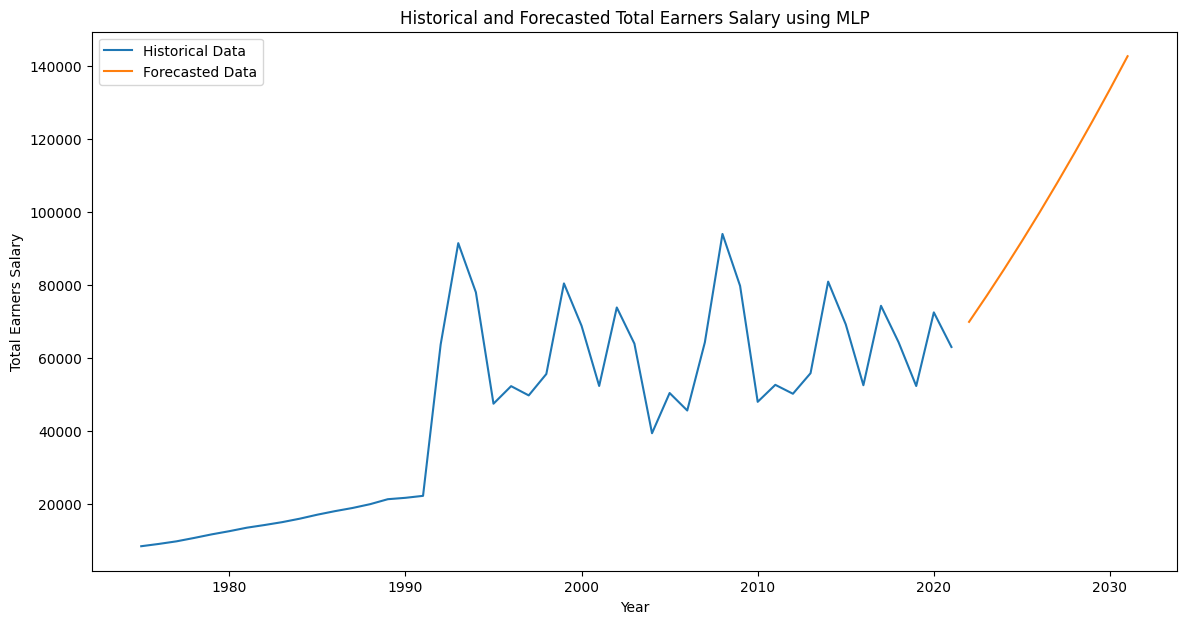

In [102]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

x = df[['year']].iloc[1:]
y = df['salary_diff'].dropna()

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

tss = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tss.split(x_scaled):
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

mlp_model = Sequential()
mlp_model.add(Dense(50, activation='relu', input_dim=x_train.shape[1]))
mlp_model.add(Dense(1))
mlp_model.compile(optimizer='adam', loss='mse')

mlp_model.fit(x_train, y_train, epochs=100, verbose=0)

last_known_year = df['year'].iloc[-1]
future_years = np.arange(last_known_year + 1, last_known_year + 11).reshape(-1, 1)
future_years_scaled = scaler_x.transform(future_years)
predicted_diff_scaled = mlp_model.predict(future_years_scaled, verbose=0)
predicted_diff = scaler_y.inverse_transform(predicted_diff_scaled)

predicted_salaries = np.cumsum(np.insert(predicted_diff.flatten(), 0, df['total_earners_salary'].iloc[-1]))

plt.figure(figsize=(14, 7))
plt.plot(df['year'], df['total_earners_salary'], label='Historical Data')
plt.plot(future_years.flatten(), predicted_salaries[1:], label='Forecasted Data', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Earners Salary')
plt.title('Historical and Forecasted Total Earners Salary using MLP')
plt.legend()
plt.show()

In [103]:
y_pred_scaled = mlp_model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
residuals = y_test.flatten() - y_pred.flatten()
rss = np.sum(residuals**2)

print('RSS:', rss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
RSS: 331291398.6779885


Here we see that since MLP models are better for multivariant time series analysis, for our univariate time series analysis it is giving us greater RSS.

# Unobserved Components Model

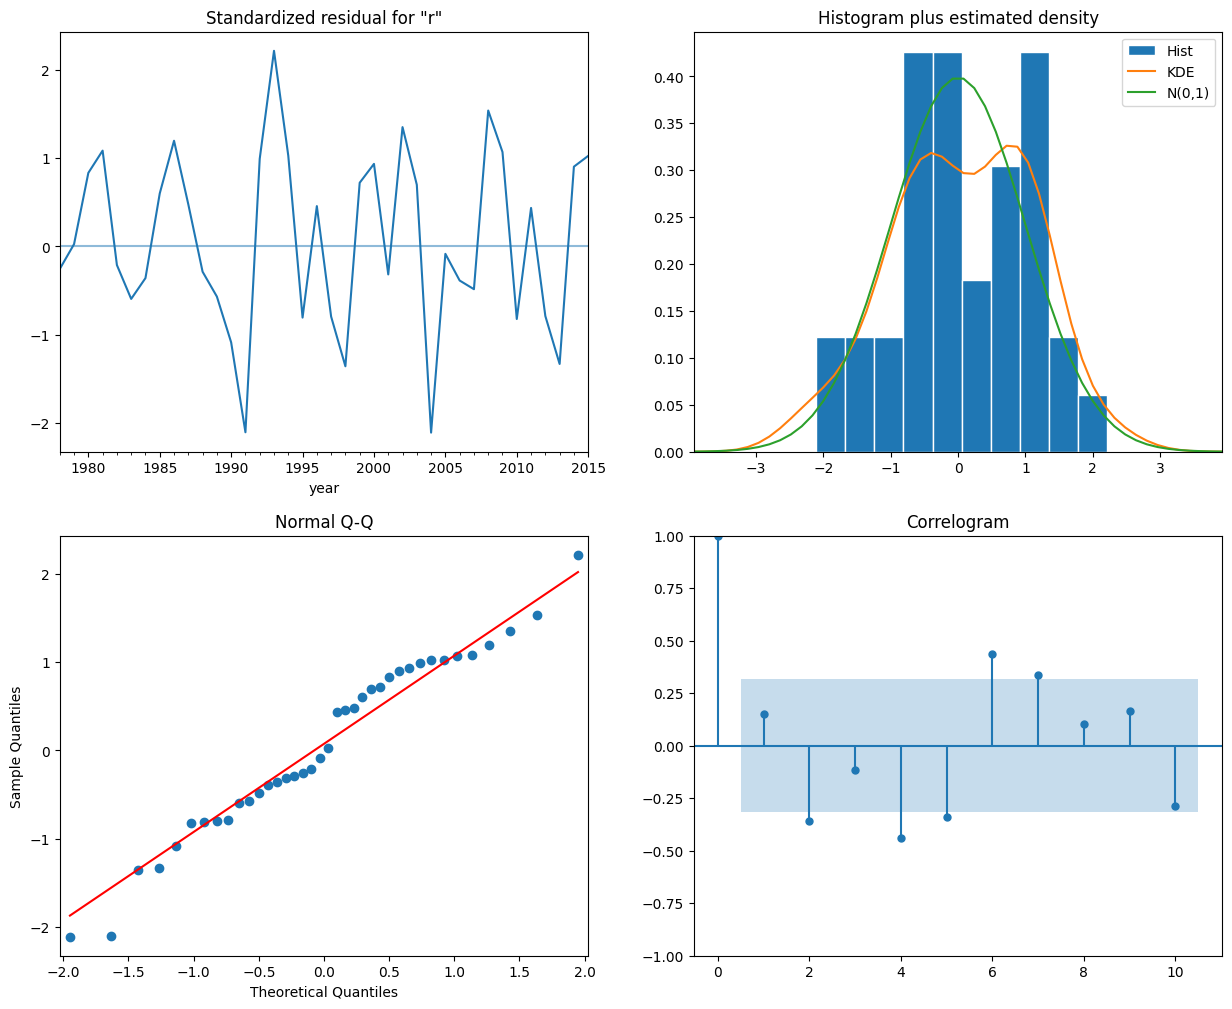

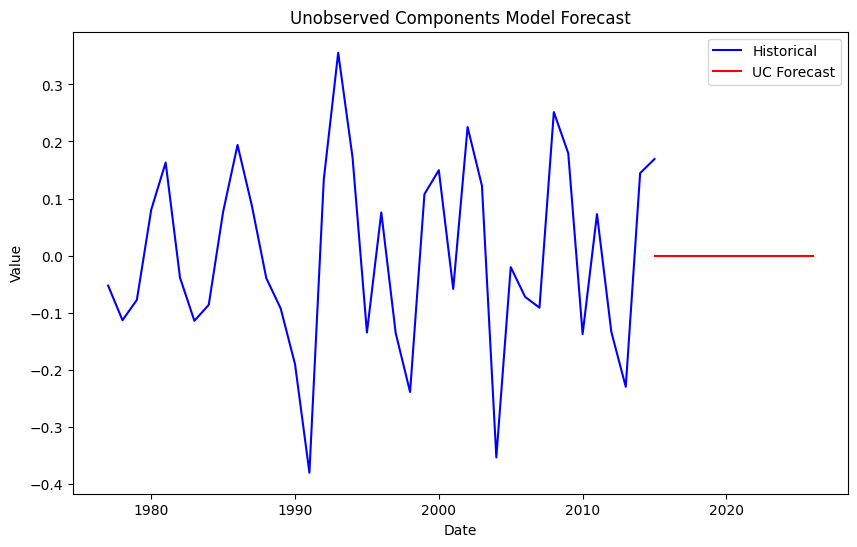

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

uc_model = UnobservedComponents(sal_log_decompose, 'local level')
uc_results = uc_model.fit()

uc_results.plot_diagnostics(figsize=(15, 12))
plt.show()

uc_forecast = uc_results.forecast(steps=12)

forecast_index = pd.date_range(start=sal_log_decompose.index[-1], periods=12, freq='YS')

plt.figure(figsize=(10, 6))
plt.plot(sal_log_decompose.index, sal_log_decompose, label='Historical', color='blue')
plt.plot(forecast_index, uc_forecast, label='UC Forecast', linestyle='-', color='red')
plt.legend()
plt.title("Unobserved Components Model Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [105]:
residuals = sal_log_decompose.values.flatten()[-12:] - uc_forecast
rss = np.sum(residuals**2)
print("RSS:", rss)

RSS: 0.37870761372019773


**Best model after analysis is "Unobserved Components Model"**

This model is not learned in our class. we have used external code/ material for reference (find it below).

**Why? - Explanation below**

# **Summary of all the models:**

1. **AR (Autoregressive):** RSS = 4.32
2. **MA (Moving Average):** RSS = 3.4
3. **ARIMA (Autoregressive Integrated Moving Average):** RSS = 3.04
4. **SARIMAX (Seasonal ARIMA with eXogenous factors):** RSS = 1.56
5. **LSTM (Long Short-Term Memory network):** RMSE = 0.448
6. **NAIVE:** RSS = 0.488
7. **MLP (Multilayer Perceptron):** RSS = 875890796.419
8. **Unobserved Components:** RSS = 0.37

Based on the summary of model performance metrics for the time series analysis, it's clear that each model has its strengths and weaknesses, which were carefully evaluated to arrive at the final decision.

The AR, MA, and ARIMA models provided reasonable fits to the data, with RSS scores steadily improving from AR to ARIMA. However, the introduction of seasonality in the SARIMAX model significantly improved the RSS to 1.56, indicating a better fit to the historical data, likely due to the capture of seasonal patterns which are evident in the dataset.

The deep learning models, LSTM and MLP, showed a divergence in performance. The LSTM model achieved a low RMSE of 0.448, suggesting good predictive capability, but RMSE and RSS are not directly comparable. The MLP model did not perform as well, with a significantly higher RSS, indicating that this model did not capture the underlying patterns in the data effectively.

Interestingly, the NAIVE model had an RSS of 0.488, which was unexpectedly low for such a simple model. This suggests the time series may have strong persistence, making the naive approach surprisingly effective.

The best performance came from the Unobserved Components model, which achieved the lowest RSS of 0.37. This indicates that the model's structure, which captures the unobserved components or hidden states within the time series, provided the best fit to the data among all models tested.

After reviewing these metrics and considering model complexity, interpretability, and the underlying patterns in the data, the final decision was to select the Unobserved Components model for forecasting. This model strikes a balance between capturing the complexity of the data with its trend, seasonality, and residuals, while also remaining relatively interpretable and simple compared to black-box models like LSTM and MLP.



From the above results, we chose UCM for its robust structured decomposition, flexibility in handling diverse data patterns, interpretability, and forecasting accuracy. It has the ability to dissect complex time series into trend, seasonality, and irregular components and allows us to get deeper insights. And most importantly it gives least RSS.

# **Group Contribution**


*   Paul : Data pre-processing & Visualization
*   Jui :  Description of Time series Visualization and checking for stationarity.
*   Dhyey : Data Transformation, Build multiple TS models and Predictions/ Forcasting for next 10 years.


Predictions, comparison of models and selecting the best were done together.






# **References**

[1] InfluxData, "Time Series Forecasting Methods," InfluxData, 2021. [Online]. Available: https://www.influxdata.com/time-series-forecasting-methods/.

[2] S. Jain, "A Comprehensive Guide to Time Series Analysis," Analytics Vidhya, Oct. 2021. [Online]. Available: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/.

[3] Y. Le, "A Guide to Time Series Models in Machine Learning: Usage, Pros, and Cons," Medium, 2021. [Online]. Available: https://medium.com/@yennhi95zz/a-guide-to-time-series-models-in-machine-learning-usage-pros-and-cons-ac590a75e8b3.

[4] ScienceDirect. (n.d.). "A review of time series forecasting techniques for software effort estimation." Retrieved from: https://www.sciencedirect.com/science/article/abs/pii/S1574070605010074

[5] Builtin. (n.d.). "Time Series Model: Definition, Types, and Examples." Retrieved from: https://builtin.com/data-science/time-series-model

[6] Brownlee, J. (n.d.). "Time Series Forecasting Methods in Python Cheat Sheet." Retrieved from: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

[7] Das, D. (n.d.). "An End-to-End Project on Time Series Analysis and Forecasting with Python." Retrieved from: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

[8] Pratama, A. G. (n.d.). "How to Model Time Series in Python." Retrieved from: https://towardsdatascience.com/how-to-model-time-series-in-python-9983ebbf82cf

[9] Analytics Vidhya. (n.d.). "Understanding Classical Time Series Analysis with Unobserved Components Model (UCM) in Python." Retrieved from: https://medium.com/analytics-vidhya/tsa-ucm-python-5fde69d42e28

[10] Koopman, S. J., & Commandeur, J. J. F. (2010). "Forecasting Economic Time Series Using State Space Models: A Survey." Journal of Economic Surveys, 24(3), 513–553. Retrieved from: https://www2.gwu.edu/~forcpgm/SiemJanKoopman-final-2010UCForecasting.pdf